Start by importing everything we need

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Then, we load the new datasets in and read the file paths

In [2]:
# Load data
file_path_trainC = "/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx"
file_path_trainFCM = "/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
file_path_trainQ = "/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx"
file_path_trainS = "/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx"

train_cat = pd.read_excel(file_path_trainC)
train_FCM = pd.read_csv(file_path_trainFCM)
train_Quant = pd.read_excel(file_path_trainQ)
train_Solutions = pd.read_excel(file_path_trainS)

We will preprocess the data by using pd.concat and also merge the dataframes.

In [3]:
# Preprocess categorical data
columns_to_encode = train_cat.columns[1:].tolist()
train_encoded = pd.get_dummies(train_cat[columns_to_encode], drop_first=True)
cat_train_final = pd.concat([train_cat[['participant_id']], train_encoded], axis=1)

# Merge dataframes
train_cat_FCM = pd.merge(cat_train_final, train_FCM, on='participant_id')
train_df = pd.merge(train_cat_FCM, train_Quant, on='participant_id')

Use StandardScaler() to scale the data and also handle any NaN values that will make it hard for us to use models.

In [4]:
# Handle missing values
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if train_df[col].isna().sum() > 0:
        train_df[col] = train_df[col].fillna(train_df[col].mean())

# Scale numeric features
scaler = StandardScaler()
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

Visualizing the data to get a better understanding

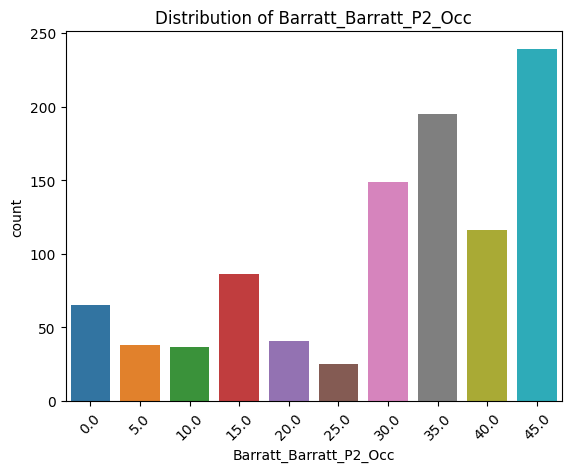

In [5]:
sns.countplot(x='Barratt_Barratt_P2_Occ', data=train_cat[['Barratt_Barratt_P2_Occ']])
plt.title(f"Distribution of Barratt_Barratt_P2_Occ")
plt.xticks(rotation=45)
plt.show()

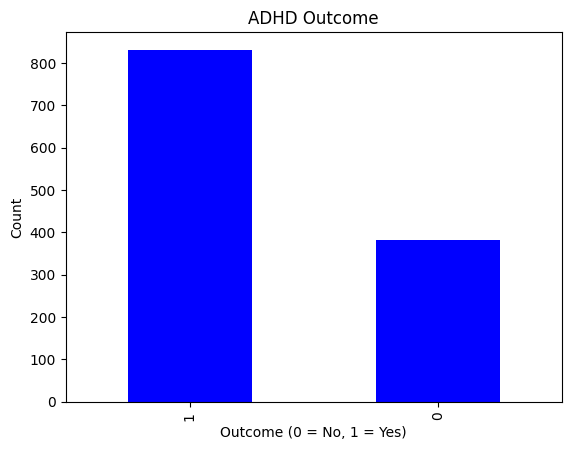

In [6]:
train_Solutions['ADHD_Outcome'].value_counts().plot(kind='bar', color='blue')
plt.title('ADHD Outcome')
plt.xlabel('Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


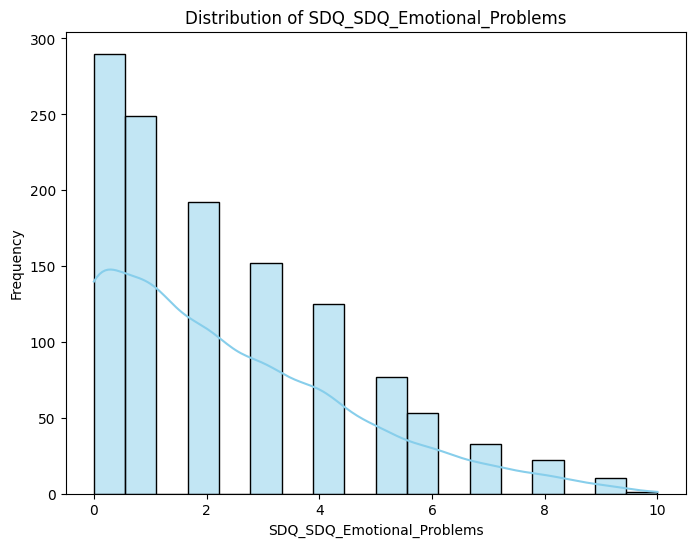

In [7]:
# Plot the distribution of the SDQ_SDQ_Emotional_Problems variable
plt.figure(figsize=(8, 6))
sns.histplot(train_Quant['SDQ_SDQ_Emotional_Problems'], kde=True, color='skyblue')
plt.title('Distribution of SDQ_SDQ_Emotional_Problems')
plt.xlabel('SDQ_SDQ_Emotional_Problems')
plt.ylabel('Frequency')
plt.show()


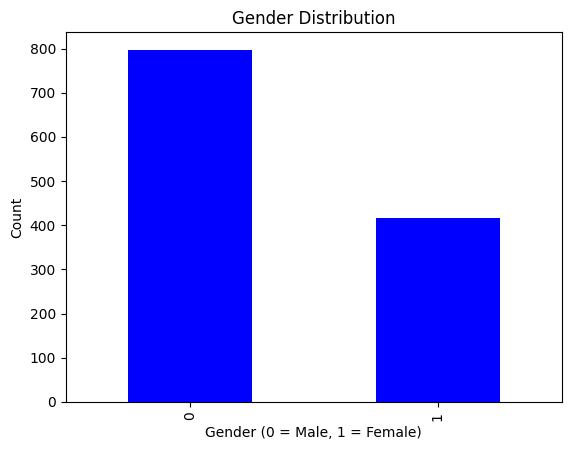

In [8]:
train_Solutions['Sex_F'].value_counts().plot(kind='bar', color='blue')
plt.title('Gender Distribution')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.show()

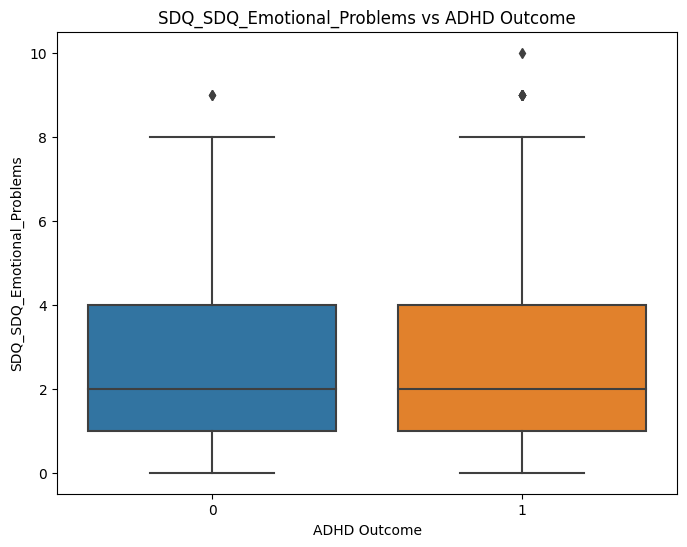

In [9]:
# Check for correlation with ADHD outcome
train_Quant_copy = train_Quant.copy()
train_Quant_copy['ADHD_Outcome'] = train_Solutions['ADHD_Outcome']

plt.figure(figsize=(8, 6))
sns.boxplot(x='ADHD_Outcome', y='SDQ_SDQ_Emotional_Problems', data=train_Quant_copy)
plt.title('SDQ_SDQ_Emotional_Problems vs ADHD Outcome')
plt.xlabel('ADHD Outcome')
plt.ylabel('SDQ_SDQ_Emotional_Problems')
plt.show()

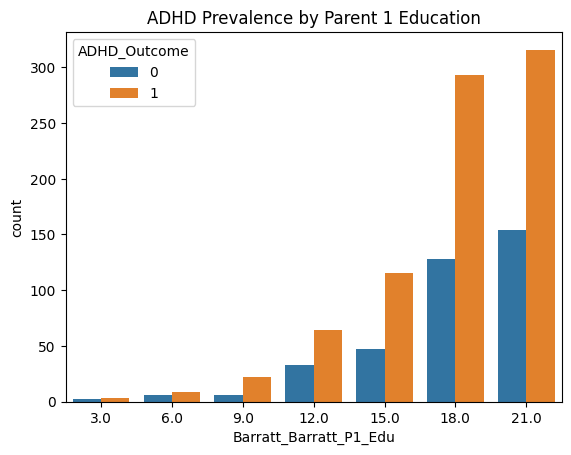

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_cat, x='Barratt_Barratt_P1_Edu', hue=train_Solutions['ADHD_Outcome'])
plt.title('ADHD Prevalence by Parent 1 Education')
plt.show()

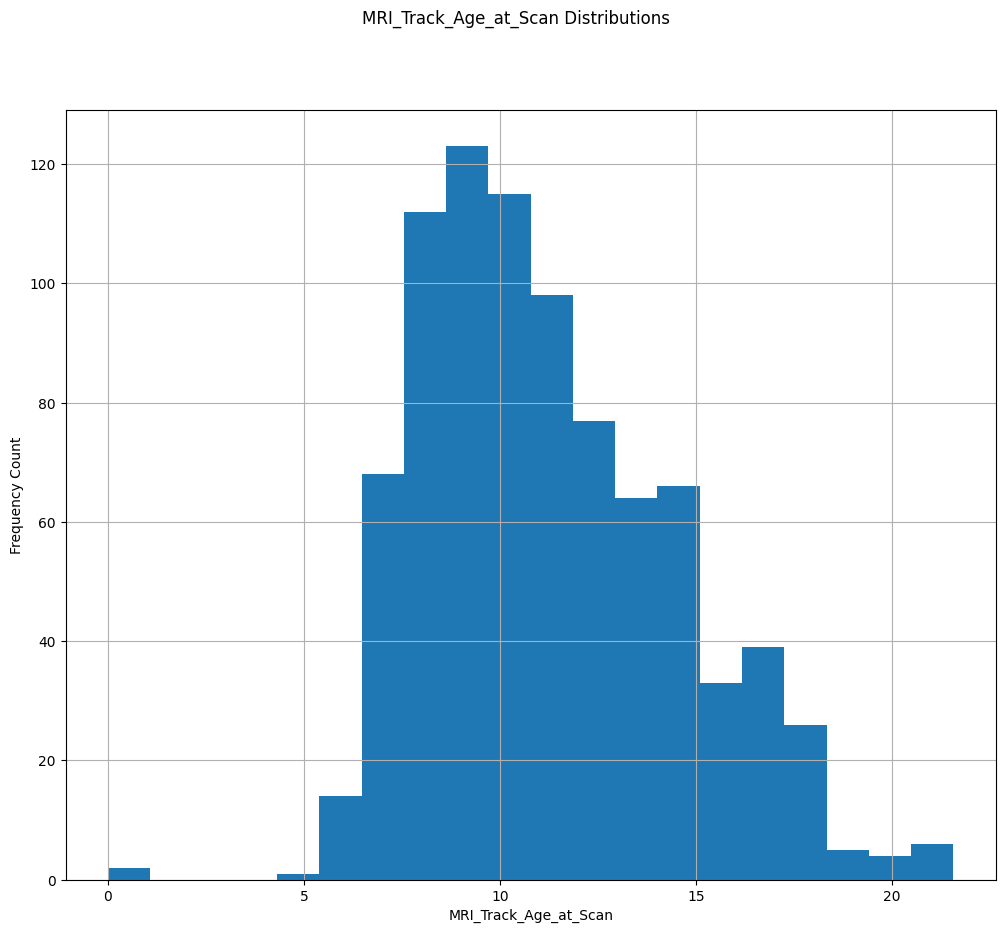

In [11]:
# Distribution of MRI_Track_Age_at_Scan
train_Quant['MRI_Track_Age_at_Scan'].hist(figsize=(12, 10), bins=20)
plt.suptitle("MRI_Track_Age_at_Scan Distributions")
plt.xlabel('MRI_Track_Age_at_Scan')
plt.ylabel('Frequency Count')
plt.show()

Split the data

In [12]:
# Split data
X_train = train_df.drop(columns=['participant_id'])
Y_train = train_Solutions.drop(columns=['participant_id'])

Train the model in RandomForest and use a MultiOutput Classifier for best accuracy.

In [13]:
# Train model
model = RandomForestClassifier()
multioutput_classifier = MultiOutputClassifier(model)
multioutput_classifier.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier())

Load data

In [14]:
# Load test data
file_path_testC = "/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
file_path_testFCM = "/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
file_path_testQ = "/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"

test_cat = pd.read_excel(file_path_testC)
test_FCM = pd.read_csv(file_path_testFCM)
test_Quant = pd.read_excel(file_path_testQ)

Encode data to preprocess test data for final testing

In [15]:
# Preprocess test data
columns_to_encode = test_cat.columns[1:].tolist()
test_encoded = pd.get_dummies(test_cat[columns_to_encode], drop_first=True)
cat_test_final = pd.concat([test_cat[['participant_id']], test_encoded], axis=1)

In [16]:
# Merge test dataframes
test_cat_FCM = pd.merge(cat_test_final, test_FCM, on='participant_id')
test_df = pd.merge(test_cat_FCM, test_Quant, on='participant_id')

Scaling & NaN values handling

In [17]:
# Handle missing values in test data
numeric_cols = test_df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if test_df[col].isna().sum() > 0:
        test_df[col] = test_df[col].fillna(test_df[col].mean())

# Scale numeric features in test data
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [18]:
# Make predictions on test data
X_test = test_df.drop(columns=['participant_id'])
y_pred = multioutput_classifier.predict(X_test)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'participant_id': test_df['participant_id'],
    'ADHD_Outcome': y_pred[:, 0],
    'Sex_F': y_pred[:, 1]
})

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


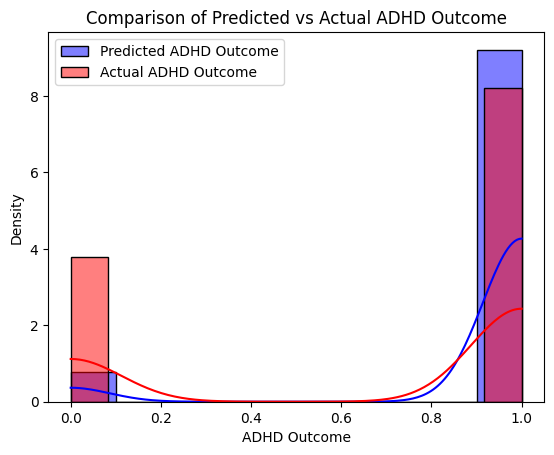

In [19]:
# If actual values are available (for validation purposes), compare them
# For example, if you have actual values in a 'ADHD_Outcome' column for the test set:

# Plot a comparison between actual and predicted values
sns.histplot(submission_df['ADHD_Outcome'], kde=True, color='blue', label='Predicted ADHD Outcome', stat="density")
sns.histplot(train_Solutions['ADHD_Outcome'], kde=True, color='red', label='Actual ADHD Outcome', stat="density")
plt.title('Comparison of Predicted vs Actual ADHD Outcome')
plt.xlabel('ADHD Outcome')
plt.ylabel('Density')
plt.legend()
plt.show()

Create a submission.csv for Kaggle to grade

In [20]:
# Save to CSV
submission_df.to_csv('submission.csv', index=False)